In [1]:
# Notes

# Environment.yml for deploy
# Create tiffs from cubes and clip to overlap using the warp/translate
# Plot axes/label axes
# Function documentation
# Bin script tiff creation
# Analysis bin script
    # - Quiver png
    # - Homography.txt (9 numbers)
    # - Dataframe to csv (keep names the same)
    # - Stats to csv (Dataframe describe data + quantile data(x, y, magnitude))

# Box to Histogram
# Correlation/Coregistration in Z dimension
    # - Apply homography
    # - Difference the two DTMs for some Z offset

#-------Nice To Have-------
# Specify meters or pixels for plotting

In [2]:
import os
import sys
import cv2
import json
import gdal
import math
import affine
from osgeo import ogr

import numpy as np
import pandas as pd

sys.path.insert(0, '/home/acpaquette/repos/plio')

from plio.geofuncs import geofuncs
from plio.io.io_gdal import GeoDataset
from autocnet.matcher import subpixel as sp
from autocnet.transformation import homography as hg

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['image.cmap'] = 'plasma'

/usgs/apps/anaconda/envs/autocnet/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# setup the paths to cubes and tiffs
hirise_cub1 = "ESP_023524_1985_1m_o_isis3.cub"
hirise_cub2 = "ESP_048908_1985_1m_o_isis3.cub"
ctx_cub1 = "F05_037607_2008_XN_20N282W_v6_PosAndVelAndAngles_20m_o.cub"
ctx_cub2 = "J03_045994_1986_XN_18N282W_v6_20m_o.cub"
ctx_cub3 = "F05_037607_2008_XN_20N282W_v6_PosAndVelAndAngles_6m_o.cub"
ctx_cub4 = "J03_045994_1986_XN_18N282W_v6_6m_o.cub"
hrsc_cub = "H5270_0000_ND4.IMG"

In [5]:
hirise_basepath = '/home/acpaquette/repos/mars2020_trn/TestData/HiRISE_Jezero/'
ctx_20_basepath = '/home/acpaquette/repos/mars2020_trn/TestData/CTX_Jezero/20m_ctx/'
ctx_6_basepath = '/home/acpaquette/repos/mars2020_trn/TestData/CTX_Jezero/6m_ctx/'
hrsc_basepath = '/home/acpaquette/repos/mars2020_trn/TestData/HRSC_Jezero/'

cub_image1 = os.path.join(hirise_basepath, hirise_cub1)
cub_image2 = os.path.join(ctx_20_basepath, ctx_cub2)

tiff_image1 = os.path.splitext(cub_image1)[0] + '.tiff'
tiff_image2 = os.path.splitext(cub_image2)[0] + '.tiff'

# src_in_srs = gdal.Info(cub_image1, format='json')['coordinateSystem']['wkt']
# dst_in_srs = gdal.Info(cub_image2, format='json')['coordinateSystem']['wkt']

# if 'Equirectangular' in src_in_srs:
#     out_srs = src_in_srs
# elif 'Equirectangular' in dst_in_srs:
#     out_srs = dst_in_srs

# resample = 'bilinear'
# res = 6

In [6]:
# Plot the images and there overlapping grid area
def show_initial_coregistration(source_image, destination_image):
    plt.figure(0, figsize=(10, 10))
    plt.imshow(source_image, alpha=.5, cmap='Greys')
    plt.imshow(destination_image, alpha=.5, cmap='Greys')
    plt.show()

# Show the quiver plot of the offsets
def display_quiver(comp_df, source_image, mask = [], scale = 100, scale_units = 'inches', **kwargs):
    if len(mask) != 0:
        comp_df = comp_df[mask]
    
    plt.figure(4, figsize=(20, 20))
    plt.imshow(source_image, cmap="Greys")
    plt.quiver(comp_df['destination_x'], comp_df['destination_y'], 
               -(comp_df['xoff']), (comp_df['yoff']),
               color = 'Red', scale = scale, scale_units = scale_units, **kwargs)
    plt.show()
    
# Given an index in the dataframe examine the before and after
# when the offset is applied
def examine_point(idx, size, comp_df, source_image, destination_image, mask = []):
    if len(mask) != 0:
        comp_df = comp_df[mask]
        
    plt.figure(2, figsize=(5, 5))
    plt.text(20, 50, 'Before Offset Correction', fontsize=12)
    x, y = int(comp_df.iloc[idx]['source_x']), int(comp_df.iloc[idx]['source_y'])
    plt.imshow(source_image[y - size:y + size, x - size:x + size], alpha = .5, cmap='Greys')

    x, y = int(comp_df.iloc[idx]['destination_x']), int(comp_df.iloc[idx]['destination_y'])
    plt.imshow(destination_image[y - size:y + size, x - size:x + size], alpha = .5, cmap='Greys')

    plt.figure(3, figsize=(5, 5))
    plt.text(20, 50, 'After Offset Correction', fontsize=12)
    x, y = int(comp_df.iloc[idx]['offset_source_x']), int(comp_df.iloc[idx]['offset_source_y'])
    plt.imshow(source_image[y - size: y + size, x - size: x + size], alpha = .5, cmap='Greys')

    x, y = int(comp_df.iloc[idx]['destination_x']), int(comp_df.iloc[idx]['destination_y'])
    plt.imshow(destination_image[y - size:y + size, x - size:x + size], alpha = .5, cmap='Greys')
    plt.show()
    
    offset_x, offset_y, corr = comp_df.iloc[idx][['xoff', 'yoff', 'corr']]
    print('X Offset: {}\nY Offset: {}\nCorrelation: {}'.format(offset_x, offset_y, corr))
    
def compute_homography(comp_df):
    x1 = np.array([*zip(comp_df['offset_source_x'].__array__(), comp_df['offset_source_y'].__array__())])
    x2 = np.array([*zip(comp_df['destination_x'].__array__(), comp_df['destination_y'].__array__())])
    H, mask = hg.compute_homography(x1, x2)
    
    return H, mask

# Apply the homography to the source image and display
def apply_homography(comp_df, source_image, destination_image):
    H, mask = compute_homography(comp_df)

    w, h = source_image.shape
    result = cv2.warpPerspective(source_image, H, (h, w))
    result[result == 0] = np.NAN

    plt.figure(0, figsize=(30, 30))
    plt.imshow(result, cmap='Greys', alpha = .5)
    plt.imshow(destination_image, cmap='Greys', alpha = .5)
    
def generate_point_grid(source_geo, destination_geo, source_raster, destination_raster, size):
    # Compute the overlap and get the corners now that
    # we have the geometry
    overlap_hull = source_geo.compute_overlap(destination_geo)[0]

    # Get the lats and lons of the assocaited corners
    overlap_lon = [i[0] for i in overlap_hull]
    overlap_lat = [i[1] for i in overlap_hull]

    # Define a ratio so the distrabution is even
    overlap_ratio = (max(overlap_lon) - min(overlap_lon)) / (max(overlap_lat) - min(overlap_lat))

    lon = np.linspace(min(overlap_lon) + .001, max(overlap_lon) - .001, size)
    lat = np.linspace(min(overlap_lat) + .001, max(overlap_lat) - .001, round(size/overlap_ratio))
    print('Generateing', len(lon), 'by', len(lat), 'point grid.')

    # Get the lat, lon position for the grid
    lonv, latv = np.meshgrid(lon, lat, sparse=True)

    coords = []

    # Begin looping over each point in the grid
    for lat_val in latv:
        for lon_val in lonv[0]:
            # Find the point in pixel space for each image and get the value
            x1, y1  = source_geo.latlon_to_pixel(lat_val[0], lon_val)
            x2, y2  = destination_geo.latlon_to_pixel(lat_val[0], lon_val)
            point_val1 = source_raster[y1 - 1, x1 - 1]
            point_val2 = destination_raster[y2 - 1, x2 - 1]

            # If either is zero then the point should be ignored
            # as it lies outside of the true overlap
            if point_val1 > 0 and point_val2 > 0:
                coords.append([x1, y1, x2, y2, lat_val[0], lon_val])

    # Build dataframe after grid contruction for data storage and 
    # ease of access
    df = pd.DataFrame(coords, columns = ['source_x', 
                                         'source_y', 
                                         'destination_x', 
                                         'destination_y', 
                                         'lat', 
                                         'lon'])
    return df

# The Meat and Potatoes of offset calculation
def compute_offsets(df, s_img, d_img, template_size, search_size, corr_threshold=0.9):
    offsets = []

    # Iterate through each point in the dataframe and calculate offsets
    print('Computing Offsets')
    for idx, row in df.iterrows():

        x, y = row['source_x'], row['source_y']
        s_template = sp.clip_roi(s_img, (x, y), template_size)


        x, y = row['destination_x'], row['destination_y']
        d_search = sp.clip_roi(d_img, (x, y), search_size)

        xoff, yoff, corr = sp.subpixel_offset(s_template, d_search)
        mag = np.linalg.norm([xoff, yoff])
        # Apply the offsets to the source points and 
        # save those as well
        offset_source_x = row['source_x'] - xoff
        offset_source_y = row['source_y'] + yoff
        offsets.append([offset_source_x, offset_source_y, xoff, yoff, mag, corr])
        sys.stdout.write('%s%s\r' % (round((idx/len(df) * 100)), '% complete'))
        sys.stdout.flush()
        
    off_df = pd.DataFrame(offsets, columns = ['offset_source_x', 'offset_source_y', 'xoff', 'yoff', 'mag', 'corr'])
    comp_df = df.merge(off_df, left_index=True, right_index=True)
    corr_mask = comp_df['corr'] > corr_threshold
    
    H, mask = compute_homography(comp_df[corr_mask])
    mask_index = comp_df[corr_mask][mask].index.__array__()
    full_mask = [True if i in mask_index else False for i, val in comp_df.iterrows()]
    return comp_df, H, full_mask

In [10]:
tiff_geo1 = GeoDataset(tiff_image1)
tiff_geo2 = GeoDataset(tiff_image2)

# Setup and redefine all 0 values as NaNs
arr_image1 = tiff_geo1.read_array(1)
arr_image1[arr_image1 == 0] = np.NaN

arr_image2 = tiff_geo2.read_array(1)
arr_image2[arr_image2 == 0] = np.NaN

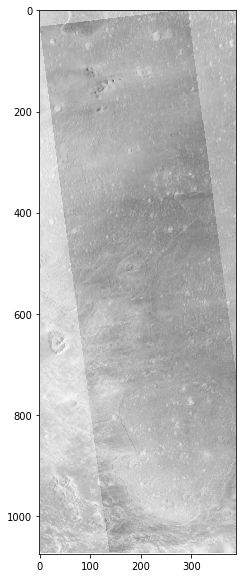

In [11]:
show_initial_coregistration(arr_image1, arr_image2)

In [12]:
# Generate a dataframe of points associated with a grid where each point
# in the grid is seperated by
x = tiff_geo1.footprint
y = tiff_geo2.footprint
print(x, '\n' + str(y))
df = generate_point_grid(tiff_geo1, tiff_geo2, arr_image1, arr_image2, 20)

POLYGON ((77.452703194141 18.5215622495304,77.452703194141 18.1591816571781,77.5984652201151 18.1591816571781,77.5984652201151 18.5215622495304,77.452703194141 18.5215622495304)) 
POLYGON ((-106.593095085998 18.5218996616275,-106.593095085998 18.1591816571781,-106.454964407326 18.1591816571781,-106.454964407326 18.5218996616275,-106.593095085998 18.5218996616275))


KeyError: 'coordinates'

In [ ]:
# Generate a dataframe of points associated with a grid where each point
# in the grid is seperated by
x = tiff_geo1.footprint
y = tiff_geo2.footprint
print(x, '\n' + str(y))
df = generate_point_grid(tiff_geo1, tiff_geo2, arr_image1, arr_image2, 20)

In [ ]:
comp_df, H, mask = compute_offsets(df, tiff_geo1, tiff_geo2, 25, 101, corr_threshold=.7)

In [ ]:
H.round(12)

In [ ]:
# Add units
comp_df[mask][['xoff', 'yoff', 'corr']].describe([.25, .5, .75, .99])

In [ ]:
# Add descriptions/units
plt.figure(0, figsize=(10, 10))
comp_df[mask][['xoff', 'yoff']].plot(kind='box', figsize=(10, 10))

In [ ]:
plt.figure(1, figsize=(10, 10))
comp_df['corr'][mask].plot(kind='box', figsize=(10, 10))

In [ ]:
display_quiver(comp_df[mask], arr_image2, scale = 5)

In [ ]:
examine_point(10, 201, comp_df[mask], arr_image1, arr_image2)

In [ ]:
apply_homography(comp_df[mask], arr_image1, arr_image2)